<a href="https://colab.research.google.com/github/DiklaGelbard/kaggle_notebooks/blob/main/diabetes_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import pprint
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
np.random.seed(0)

import os

from matplotlib import pyplot as plt
%matplotlib inline

In [44]:
# Useful functions
def get_stacked_bar_plot(cols, xtickslabels=None, legend_mapper=None, kind="barh"):
    ax = data.groupby(cols).size().unstack(1).apply(lambda x: x/x.sum(), axis=1).plot(kind=kind, stacked=True)
    if xtickslabels is not None:
      labels = ax.get_xticklabels() if kind=="bar" else ax.get_yticklabels()
      ticks =  ax.get_xticks() if kind=="bar" else  ax.get_yticks()
      tickslabels = [xtickslabels[a.get_text()] for a in labels]
      if kind == "bar":
        ax.set_xticks(ticks=ticks, labels = tickslabels, rotation=45, ha='right', rotation_mode='anchor')
        plt.rcParams["figure.figsize"] = (6,10)
      else:
        ax.set_yticks(ticks=ticks, labels = tickslabels, rotation=10, ha='right', rotation_mode='anchor')
        plt.rcParams["figure.figsize"] = (10, 6) 
    if legend_mapper is not None:
        labels = [legend_mapper[a.get_text()] for a in ax.get_legend().texts]
        ax.set_label(labels)
    plt.tight_layout()
    return ax

## Read and pre-process Data

### Load dataset

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diklagel","key":"8f40772177035c67bbbf281673a72750"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d brandao/diabetes
! mkdir diabetes
! unzip diabetes.zip -d diabetes
df = pd.read_csv("diabetes/diabetic_data.csv")

 68% 3.00M/4.41M [00:00<00:00, 5.68MB/s]
100% 4.41M/4.41M [00:00<00:00, 6.59MB/s]
Archive:  diabetes.zip
  inflating: diabetes/description.pdf  
  inflating: diabetes/diabetic_data.csv  


In [5]:
# Categorical columns mapping (taken from external table)
admission_type_id = dict([(str(i+1), a) for i, a in enumerate(["Emergency", "Urgent", "Elective", "Newborn", "Not Available", "NULL", "Trauma Center", "Not Mapped"])])
discharge_disposition_id = dict([(str(i+1), a) for i, a in enumerate(["Discharged to home","Discharged/transferred to another short term hospital","Discharged/transferred to SNF","Discharged/transferred to ICF","Discharged/transferred to another type of inpatient care institution","Discharged/transferred to home with home health service","Left AMA","Discharged/transferred to home under care of Home IV provider","Admitted as an inpatient to this hospital","Neonate discharged to another hospital for neonatal aftercare","Expired","Still patient or expected to return for outpatient services","Hospice / home","Hospice / medical facility","Discharged/transferred within this institution to Medicare approved swing bed","Discharged/transferred/referred another institution for outpatient services","Discharged/transferred/referred to this institution for outpatient services","NULL","Expired at home. Medicaid only, hospice.","Expired in a medical facility. Medicaid only, hospice.","Expired, place unknown. Medicaid only, hospice.","Discharged/transferred to another rehab fac including rehab units of a hospital .","Discharged/transferred to a long term care hospital.","Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.","Not Mapped","Unknown/Invalid","Discharged/transferred to a federal health care facility.","Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital","Discharged/transferred to a Critical Access Hospital (CAH).","Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere"])])
admission_source_id = dict([(str(i+1), a) for i, a in enumerate(["Physician Referral","Clinic Referral","HMO Referral","Transfer from a hospital","Transfer from a Skilled Nursing Facility (SNF)","Transfer from another health care facility","Emergency Room","Court/Law Enforcement","Not Available","Transfer from critial access hospital","Normal Delivery","Premature Delivery","Sick Baby","Extramural Birth","Not Available","NULL","Transfer From Another Home Health Agency","Readmission to Same Home Health Agency","Not Mapped","Unknown/Invalid","Transfer from hospital inpt/same fac reslt in a sep claim","Born inside this hospital","Born outside this hospital","Transfer from Ambulatory Surgery Center","Transfer from Hospice"])])

### Explore the table

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Handle number_of_encounters per patient

*   As in the original paper, I will keep only the first visit for each patient


number_of_encounters distribution:
1     54745
2     10434
3      3328
4      1421
5       717
6       346
7       207
8       111
9        70
10       42
11       20
12       19
13       14
14        5
15        9
16        4
17        3
18        6
19        3
20        6
21        1
22        2
23        3
28        1
40        1
dtype: int64


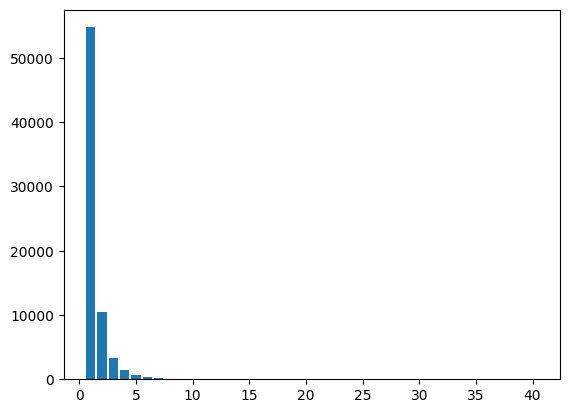

In [10]:
number_of_encounters = df.groupby("patient_nbr").size()
print("number_of_encounters distribution:")
hist_number_of_encounters = number_of_encounters.value_counts().sort_index()
print(hist_number_of_encounters)
plt.bar(hist_number_of_encounters.index, hist_number_of_encounters)
df = df.join(pd.DataFrame(number_of_encounters, columns=["encounters_total_num"]), on = "patient_nbr", how = "left").sort_values(by="encounters_total_num", ascending=False)

In [11]:
# Select first encounter per patient
data = df.sort_values(by="encounter_id").groupby("patient_nbr").first()

### Filter data by discharge_disposition_id column
*   As in the original paper, I will filter out death cases



In [ ]:
# Converting to categories names
data.loc[:, "discharge_disposition_id"] = data.discharge_disposition_id.apply(lambda x: discharge_disposition_id[str(x)])

<Axes: ylabel='discharge_disposition_id'>

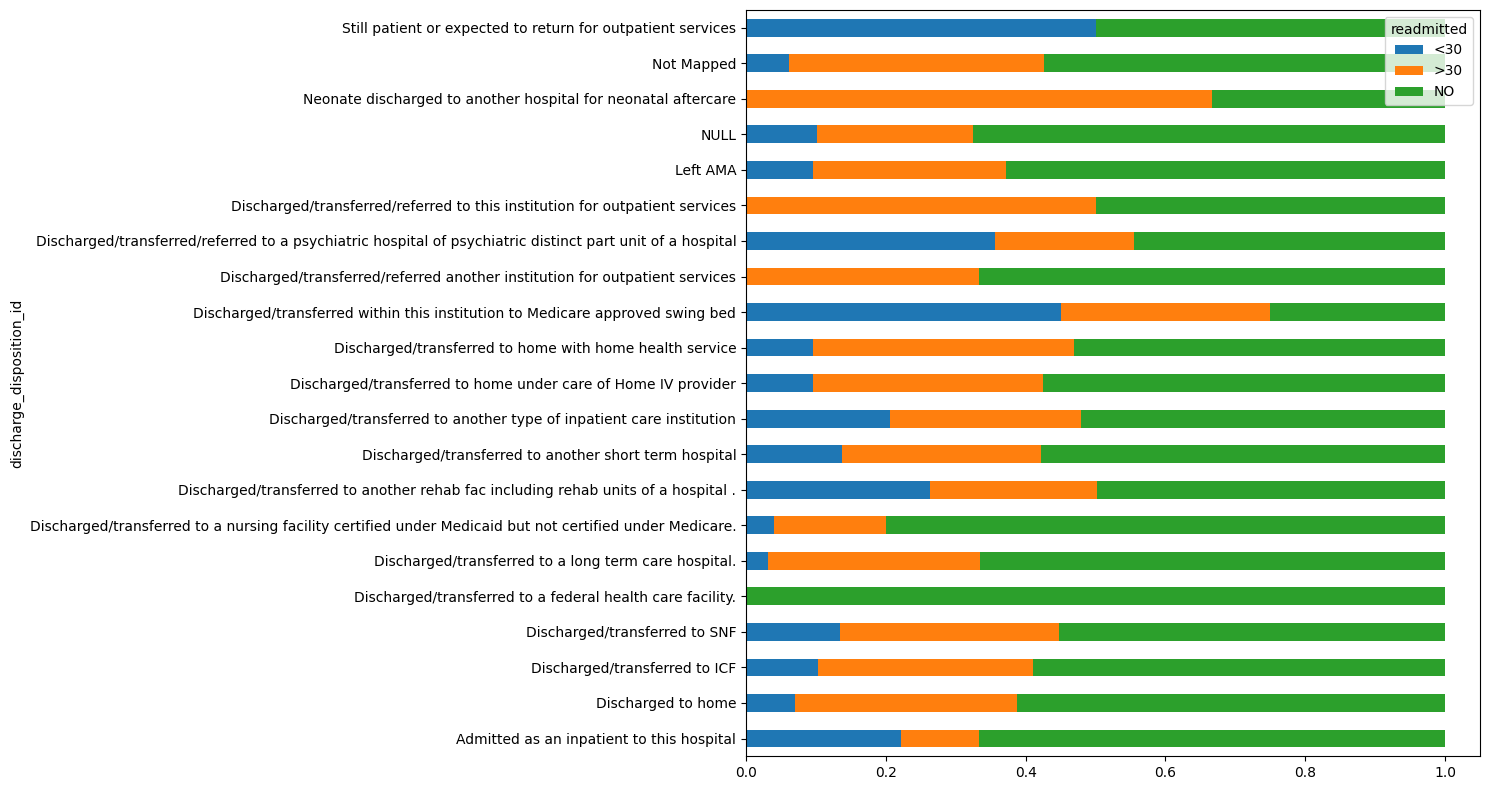

In [45]:
get_stacked_bar_plot(["discharge_disposition_id","readmitted"])

In [46]:
# Drop discharge_disposition s.a expired or hospice
discharge_disposition_ids_to_remove = ["Expired", "Hospice / home", "Hospice / medical facility", "Expired at home. Medicaid only, hospice.", "Expired in a medical facility. Medicaid only, hospice."]
data = data.loc[~data.discharge_disposition_id.isin(discharge_disposition_ids_to_remove), :]

In [51]:
print("discharge_disposition_id distribution")
data.groupby("discharge_disposition_id").size().sort_values(ascending=False)

discharge_disposition_id distribution


discharge_disposition_id
Discharged to home                                                                                           44317
Discharged/transferred to SNF                                                                                 8784
Discharged/transferred to home with home health service                                                       8289
NULL                                                                                                          2474
Discharged/transferred to another short term hospital                                                         1539
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1410
Discharged/transferred to another type of inpatient care institution                                           913
Not Mapped                                                                                                     778
Discharged/transferred to ICF                          

### Admission type

In [85]:
admission_type_id_buckets = {"Emergency": [1, 2, 7], "Elective": [3], "Newborn": [4], "NULL": [5,6,8]}
admission_type_id_categories = dict((i,key) for key, item in admission_type_id_buckets.items() for i in item)
data.loc[:, "admission_type_id"] = data.admission_type_id.apply(lambda x: admission_type_id_categories[x])

### Mapping diagnoses to disease_groups

In [52]:
# Main disease groups as described in the original paper
disease_groups = {"Circulatory": list(range(390,460)) + [785],
                  "Respiratory": list(range(460,520)) + [786],
                  "Digestive": list(range(520,579)) + [787], 
                  "Diabetes": [250],
                  "Injury": list(range(800, 1000)),
                  "Musculoskeletal": list(range(710, 740)), 
                  "Genitourinary": list(range(580,630)) + [788],
                  "Neoplasms": list(range(140,240)),
                 }
disease_groups_df = pd.DataFrame([{"disease_group":d, "diag_id":str(i)} for d in disease_groups.keys() for i in disease_groups[d] ])
disease_groups_df.head()

,disease_group,diag_id
0,Circulatory,390
1,Circulatory,391
2,Circulatory,392
3,Circulatory,393
4,Circulatory,394


In [53]:
# Add disease_group for each diagnosis column
def add_disease_group_column(data, diag_col, disease_group_col):
    data = pd.merge(data, disease_groups_df.rename(columns = {'disease_group':disease_group_col}), left_on=diag_col, right_on="diag_id", how="left").fillna({disease_group_col: "Other"}).drop("diag_id", axis=1)
    return data

for i in range(1,4):
    data = add_disease_group_column(data, diag_col="diag_%d" %i, disease_group_col="disease_group_%d" %i)
    
data[["diag_1", "diag_2", "diag_3",'disease_group_1', 'disease_group_2', 'disease_group_3']].head()

,diag_1,diag_2,diag_3,disease_group_1,disease_group_2,disease_group_3
0,401,997,560,Circulatory,Injury,Digestive
1,722,305,250,Musculoskeletal,Other,Diabetes
2,820,493,E880,Injury,Respiratory,Other
3,274,427,416,Other,Circulatory,Circulatory
4,590,220,250,Genitourinary,Neoplasms,Diabetes


#### Disease groups one hot encoding and PCA for visualization

In [74]:
disease_groups_list =["disease_group_1", "disease_group_2", "disease_group_3"]
one_hot_encoded_disease_groups = pd.get_dummies(data, columns=disease_groups_list, drop_first=False)
one_hot_encoded_disease_groups.loc[:, "total_diagnoses"] = one_hot_encoded_disease_groups.loc[:,[f"{diag}_{disease}" for diag in disease_groups_list for disease in disease_groups.keys()]].sum(axis=1)
for disease in disease_groups.keys():
    one_hot_encoded_disease_groups.loc[:, disease] = (one_hot_encoded_disease_groups.loc[:,[f"{diag}_{disease}" for diag in disease_groups_list]].sum(axis=1) /
                                                      (one_hot_encoded_disease_groups.loc[:, "total_diagnoses"] + 0.00001)).round(3)
one_hot_encoded_disease_groups = one_hot_encoded_disease_groups[disease_groups.keys()]
one_hot_encoded_disease_groups.head()

,Circulatory,Respiratory,Digestive,Diabetes,Injury,Musculoskeletal,Genitourinary,Neoplasms
0,0.333,0.0,0.333,0.000,0.333,0.0,0.000,0.000
1,0.000,0.0,0.000,0.500,0.000,0.5,0.000,0.000
2,0.000,0.5,0.000,0.000,0.500,0.0,0.000,0.000
3,1.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000
4,0.000,0.0,0.000,0.333,0.000,0.0,0.333,0.333


In [76]:
from sklearn.decomposition import PCA
pca_disease_groups = PCA(n_components=2).fit(one_hot_encoded_disease_groups.values) 
import plotly.express as px
category_vectors_disease_groups = pca_disease_groups.components_.T
category_vector_frame_disease_groups=pd.DataFrame(category_vectors_disease_groups, index=disease_groups.keys(), 
                                   columns=['col1', 'col2']).reset_index()  
px.scatter(category_vector_frame_disease_groups, x='col1', y='col2', color='index')

### Process 23 medications columns  

In [77]:
medications = ['metformin',
               'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
               'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
               'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
               'tolazamide', 'examide', 'citoglipton', 'insulin',
               'glyburide-metformin', 'glipizide-metformin',
               'glimepiride-pioglitazone', 'metformin-rosiglitazone',
               'metformin-pioglitazone']

In [78]:
# Drop medications with single value over the dataset
med_describe = data[medications].describe()
medications_to_drop = list(med_describe.columns[med_describe.loc["unique"] == 1])
print("Dropping out the following medications:", medications_to_drop)
data = data.drop(medications_to_drop, axis=1)
medications = [m for m in medications if m not in medications_to_drop]

Dropping out the following medications: ['examide', 'citoglipton', 'glimepiride-pioglitazone']


When examining the distribution of medication prescriptions among patients, it becomes apparent that numerous medications are prescribed with great rarity. This raises the issue of whether these medications should be excluded from our analysis or not.

<Axes: >

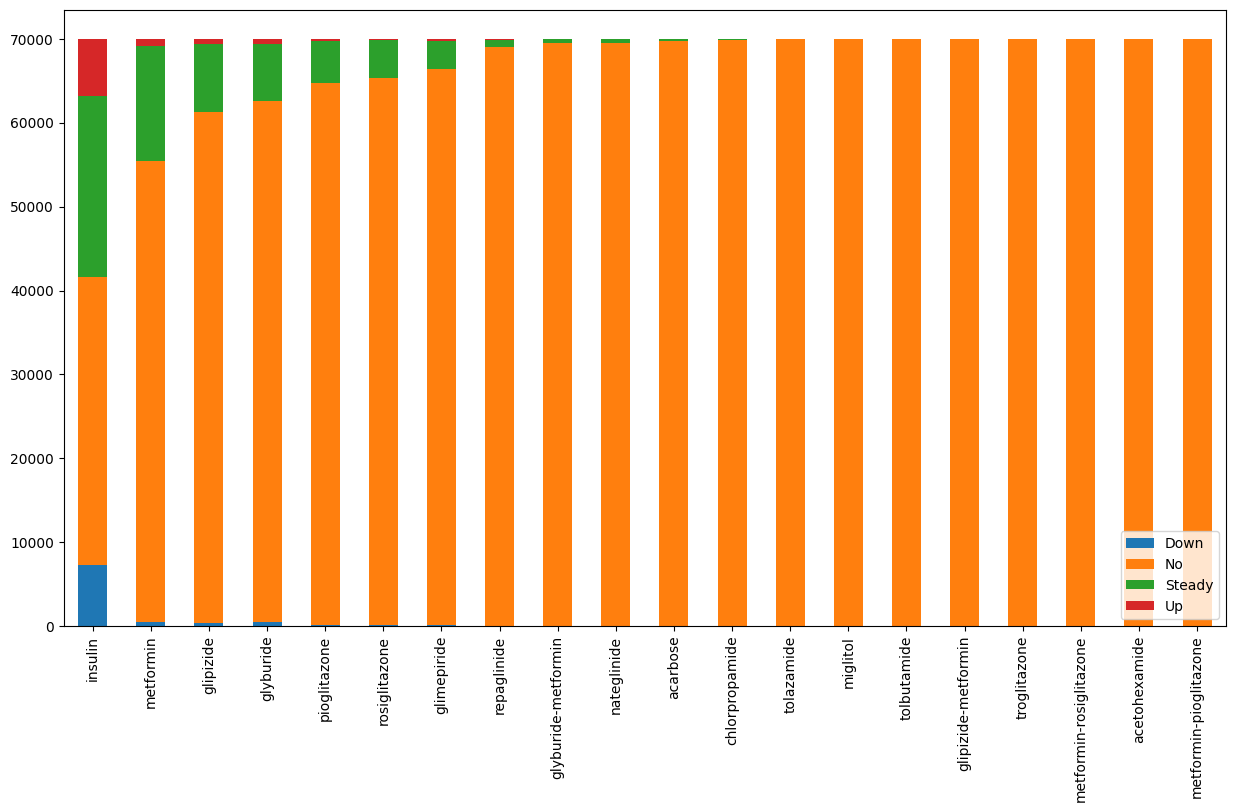

In [79]:
medications_value_counts = data[medications].apply(lambda x: x.value_counts(), axis=0).fillna(0).transpose().sort_values(by="No")
medications_value_counts.plot.bar(stacked=True)

#### Medications Binarization and PCA

In [81]:
trans_med = {"Steady": 1, "Up": 1, "Down": 1, "No": 0}
med_data = data[medications].apply(lambda x: x.map(trans_med))

In [82]:
from sklearn.decomposition import PCA
pca_med_data = PCA(n_components=2).fit(med_data.values) 
category_vectors_med = pca_med_data.components_.T
category_vector_frame_med=pd.DataFrame(category_vectors_med, index=medications, 
                                       columns=['col1', 'col2']).reset_index()  
px.scatter(category_vector_frame_med, x='col1', y='col2', color='index')

### Basic feature selection

In [98]:
y = data.loc[:, 'readmitted'].apply(lambda x: 1 if x != "NO" else 0)
readmission_counts = y.value_counts()
print("readmission distribution:")
print(readmission_counts)
print("Min expected precision:", readmission_counts[1] / readmission_counts.sum())

readmission distribution:
0    41474
1    28499
Name: readmitted, dtype: int64
Min expected precision: 0.4072856673288268


In [87]:
cols_to_choose = ['race', 'gender', 'age', 'admission_type_id',
                  'discharge_disposition_id', 'admission_source_id', 'time_in_hospital','num_lab_procedures',
                  'num_procedures', 'num_medications', 'number_outpatient',
                  'number_emergency', 'number_inpatient', 'change', 'diabetesMed', "max_glu_serum", "A1Cresult"]
processed_data = data[cols_to_choose].copy()

# Dividing age into buckets as shown in the paper
buckets = {"0-30": [0,10,20], "30-60": [30,40,50], "60-100": [60, 70, 80, 90]}
age_dict = dict((i,key) for key, item in buckets.items() for i in item)
processed_data.loc[:, "age"] = processed_data.loc[:, "age"].apply(lambda x: age_dict[int(x.split("-")[0][1:])])

categorical_features = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id','change', 'diabetesMed', "max_glu_serum", "A1Cresult"]
processed_data = pd.get_dummies(processed_data, columns=categorical_features, drop_first=True)

processed_data = pd.concat([processed_data, med_data, one_hot_encoded_disease_groups], axis=1)
processed_data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_AfricanAmerican,race_Asian,race_Caucasian,...,metformin-rosiglitazone,metformin-pioglitazone,Circulatory,Respiratory,Digestive,Diabetes,Injury,Musculoskeletal,Genitourinary,Neoplasms
0,8,77,6,33,0,0,0,0,0,1,...,0,0,0.333,0.0,0.333,0.000,0.333,0.0,0.000,0.000
1,2,49,1,11,0,0,0,0,0,1,...,0,0,0.000,0.0,0.000,0.500,0.000,0.5,0.000,0.000
2,4,68,2,23,0,0,0,0,0,1,...,0,0,0.000,0.5,0.000,0.000,0.500,0.0,0.000,0.000
3,3,46,0,20,0,0,0,0,0,1,...,0,0,1.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000
4,5,49,0,5,0,0,0,1,0,0,...,0,0,0.000,0.0,0.000,0.333,0.000,0.0,0.333,0.333


In [89]:
# Remove features with low variance
features_std = processed_data.std(axis=0)
q = features_std.quantile(0.1)
print("dropping out the following low var features", processed_data.columns[features_std <= q])
selected_fetures = processed_data.columns[features_std > q]

dropping out the following low var features Index(['gender_Unknown/Invalid',
       'discharge_disposition_id_Still patient or expected to return for outpatient services',
       'admission_source_id_11', 'admission_source_id_13',
       'admission_source_id_14', 'admission_source_id_25', 'acetohexamide',
       'troglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'],
      dtype='object')


### Train-Test split

In [90]:
# Split to train and test data
X_train, X_test, y_train, y_test = train_test_split(processed_data.loc[:,selected_fetures], y, test_size=0.2, random_state=42)

## Baseline Model
*Using features from the paper



I will use the precision-recall curve in order to estimate my model
* When data is imbalanced, the AUC might not reflect the true performance of the classifier. The definition of the False Positive Rate (FPR), is the number of false positives divided by the number of negative samples. FPR is considered better when it’s smaller since it indicates fewer false positives. In imbalanced data, the FPR tends to stay at small values due to the large numbers of negatives (i.e. making the denominator large). Thus, FPR becomes less informative for the model performance in this situation.



In [ ]:
from sklearn.linear_model import LogisticRegressionCV


In [206]:
def plot_and_select_features(feature_names, scores, xerr=None, top_features = 30, title = "Features scores", xlabel = "score", figsize=(10,6)):
    order = scores.argsort()[::-1]
    selected_fetures = list(feature_names[order][:top_features])
    plt.rcParams["figure.figsize"] = figsize
    plt.barh(selected_fetures, scores[order][:top_features], xerr=xerr[order][:top_features])
    plt.title(title)
    plt.ylabel("Feature name")
    plt.xlabel(xlabel)
    return selected_fetures

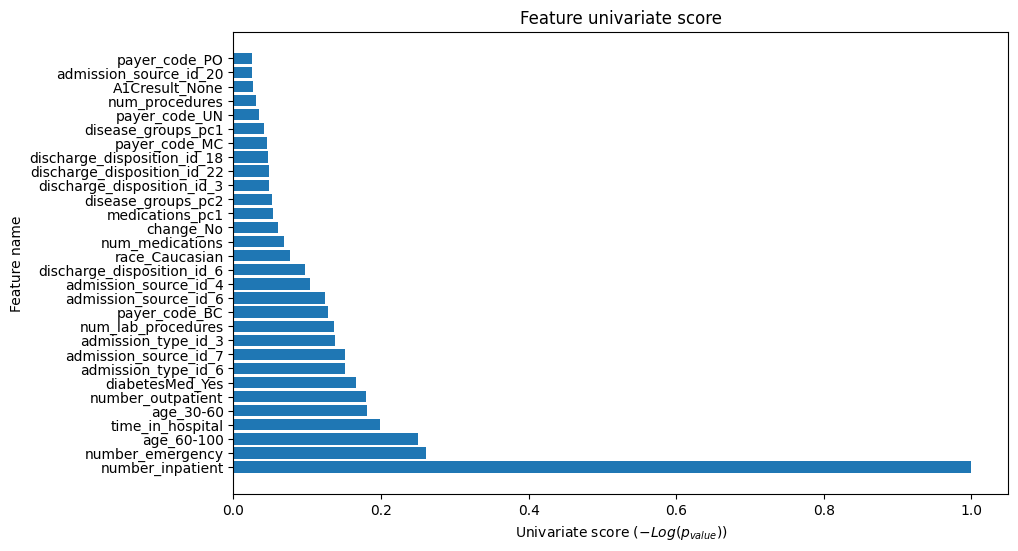

In [191]:
# Univariate feature selection
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=2)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

selected_fetures = plot_and_select_features(X_train.columns, scores, title="Feature univariate score", xlabel=r"Univariate score ($-Log(p_{value})$)")

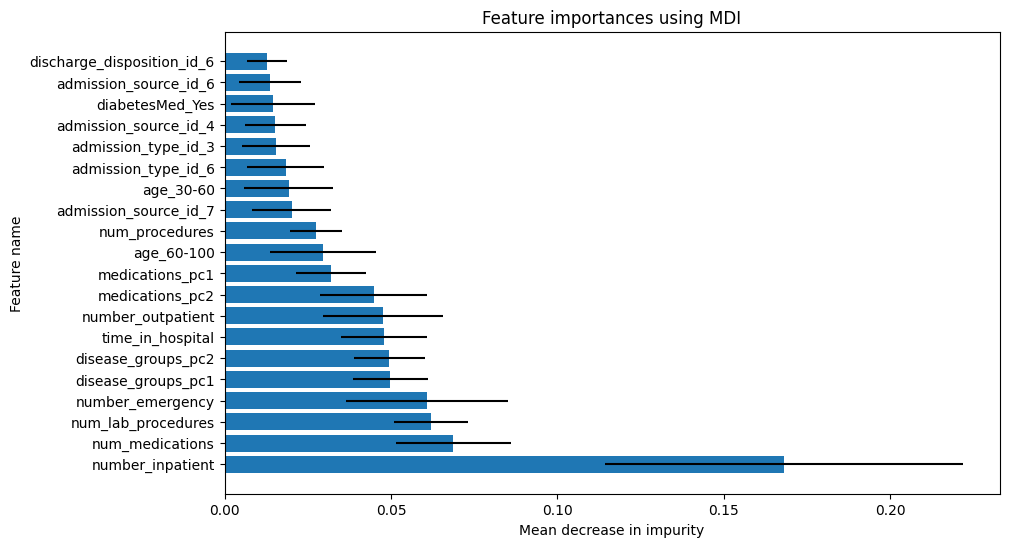

In [222]:
# Feature importance with random forest
from sklearn.ensemble import RandomForestClassifier
# Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.
forest = RandomForestClassifier(max_depth= 11, min_samples_split= 10, random_state= 42) # parameters were fine tuned after cross validatinig  
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
selected_features_mdi = plot_and_select_features(X_train.columns, importances, xerr=std, top_features=20, title="Feature importances using MDI", xlabel="Mean decrease in impurity")

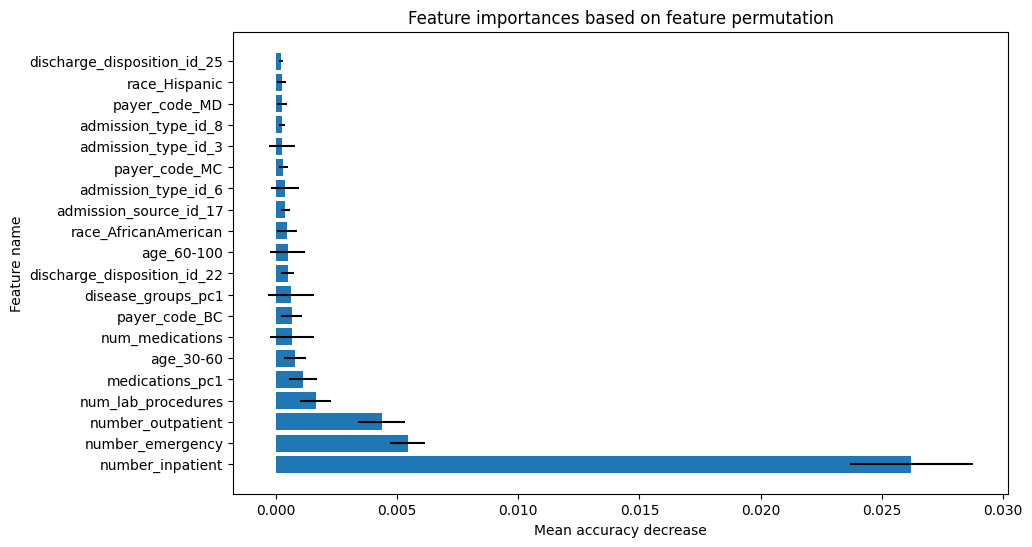

In [223]:
# Feature importance based on feature permutation
from sklearn.inspection import permutation_importance
result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42)

selected_features_permutation = plot_and_select_features(X_train.columns, result.importances_mean, xerr=result.importances_std, top_features=20, title="Feature importances based on feature permutation", xlabel="Mean accuracy decrease")

In [225]:
from sklearn.feature_selection import SequentialFeatureSelector
forest = RandomForestClassifier(max_depth = 11, min_samples_split= 10, random_state= 42) # parameters were fine tuned after cross validatinig  
sfs_forward = SequentialFeatureSelector(forest, n_features_to_select=10, direction="forward").fit(X_train, y_train)
sfs_backward = SequentialFeatureSelector(forest, n_features_to_select=10, direction="backward").fit(X_train, y_train)

print("Features selected by forward sequential selection: ", f"{X_train.columns[sfs_forward.get_support()]}")
print("Features selected by backward sequential selection: ", f"{X_train.columns[sfs_backward.get_support()]}")


KeyboardInterrupt: ignored

In [218]:
selected_features = list(set(selected_features_permutation + selected_features_mdi))
print(selected_features)
print(len(selected_features))

['num_lab_procedures', 'discharge_disposition_id_6', 'gender_Male', 'disease_groups_pc2', 'number_inpatient', 'admission_type_id_3', 'number_outpatient', 'admission_type_id_2', 'admission_source_id_7', 'num_procedures', 'A1Cresult_Norm', 'disease_groups_pc1', 'medications_pc2', 'race_Caucasian', 'A1Cresult_None', 'change_No', 'num_medications', 'admission_source_id_4', 'admission_type_id_6', 'number_emergency', 'medications_pc1', 'time_in_hospital', 'payer_code_MC', 'discharge_disposition_id_3']
24


## Train a model

In [220]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

def print_cross_validation(model, model_name, X, y):
  print("model:", model_name)
  pprint.pprint(cross_validation(model, X, y))

In [221]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
models = [(RandomForestClassifier(), {'min_samples_split': [5, 10], 'max_depth': [None] + [i for i in range(3,16, 2)], 'random_state': [42]}, "RandomForest"),
          (GradientBoostingClassifier(), {'min_samples_split': [5, 10], 'max_depth': [None] + [i for i in range(3,16, 2)] , 'random_state': [42]}, "XGBoost")
          ]
top_estimators = []
for model in models:
  clf = GridSearchCV(model[0], param_grid = model[1])
  clf.fit(processed_data_with_embeddings.loc[:, selected_features], y)
  top_estimators += clf.best_estimator_
  print_cross_validation(clf.best_estimator_, "_".join([model[2], str(clf.best_params_)]) ,processed_data_with_embeddings, y)

model: RandomForest_{'max_depth': 11, 'min_samples_split': 10, 'random_state': 42}
{'Mean Training Accuracy': 66.04333218491128,
 'Mean Training F1 Score': 0.38156600395241413,
 'Mean Training Precision': 0.7387528949876397,
 'Mean Training Recall': 0.25734246769826,
 'Mean Validation Accuracy': 61.75527387509464,
 'Mean Validation F1 Score': 0.3138158747853351,
 'Mean Validation Precision': 0.6019599011065333,
 'Mean Validation Recall': 0.22383436306154053,
 'Training Accuracy scores': array([0.6580085 , 0.66208153, 0.66452892, 0.65951518, 0.65803248]),
 'Training F1 scores': array([0.37743089, 0.38901809, 0.39982102, 0.37265486, 0.36890515]),
 'Training Precision scores': array([0.7298453 , 0.73789977, 0.73674912, 0.74653831, 0.74273198]),
 'Training Recall scores': array([0.25452871, 0.26413439, 0.27435414, 0.24830036, 0.24539474]),
 'Validation Accuracy scores': array([0.61536263, 0.6052876 , 0.61421936, 0.62376733, 0.62912677]),
 'Validation F1 scores': array([0.15295043, 0.296126

In [ ]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(min_samples_split=1000, random_state=42)
GradientBoostingClassifier_cross_validation = cross_validation(clf, processed_data_with_embeddings, y)
pprint.pprint(GradientBoostingClassifier_cross_validation)

{'Mean Training Accuracy': 63.56701872229612,
 'Mean Training F1 Score': 0.373067793613919,
 'Mean Training Precision': 0.6235766841145083,
 'Mean Training Recall': 0.2662111600000924,
 'Mean Validation Accuracy': 61.85101275731757,
 'Mean Validation F1 Score': 0.3363299478039341,
 'Mean Validation Precision': 0.6001054627266342,
 'Mean Validation Recall': 0.24983588995299266,
 'Training Accuracy scores': array([0.63382043, 0.63589267, 0.63733967, 0.6367745 , 0.63452366]),
 'Training F1 scores': array([0.37311151, 0.36929075, 0.38465036, 0.37245764, 0.36582871]),
 'Training Precision scores': array([0.61622386, 0.62698329, 0.6225471 , 0.62841075, 0.62371842]),
 'Training Recall scores': array([0.26755559, 0.26172201, 0.27830168, 0.26466073, 0.25881579]),
 'Validation Accuracy scores': array([0.62122186, 0.61764916, 0.60750268, 0.61976561, 0.62641132]),
 'Validation F1 scores': array([0.19006875, 0.27306073, 0.38009254, 0.42531591, 0.41311181]),
 'Validation Precision scores': array([0.

In [ ]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(min_samples_split=1000, random_state=42)
GradientBoostingClassifier_cross_validation = cross_validation(clf, processed_data_with_embeddings, y)
pprint.pprint(GradientBoostingClassifier_cross_validation)

## Cluster using UMAP

In [ ]:
# ! pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=6c398f2f862911bfb68a080a9223fb9512496d49f3f92558f491115458d16160
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=f7b64b9ac54dda0948640be29c037cd4d0580da84e746cf5c07f3b49b832c7ee
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import umap

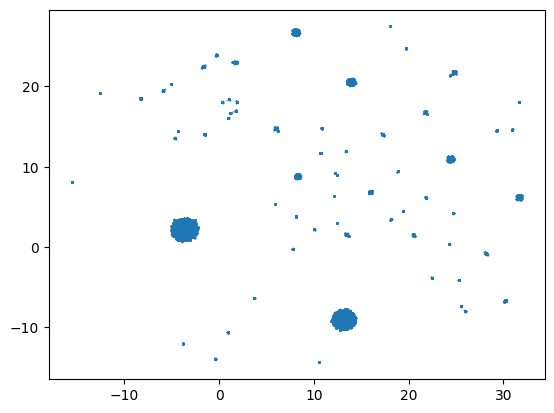

In [ ]:
clusterable_embedding = umap.UMAP(n_neighbors=30,
                                  min_dist=0.0,
                                  n_components=2,
                                  random_state=42,
                                  ).fit_transform(data[medications].apply(lambda x: x.map(trans_med)))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

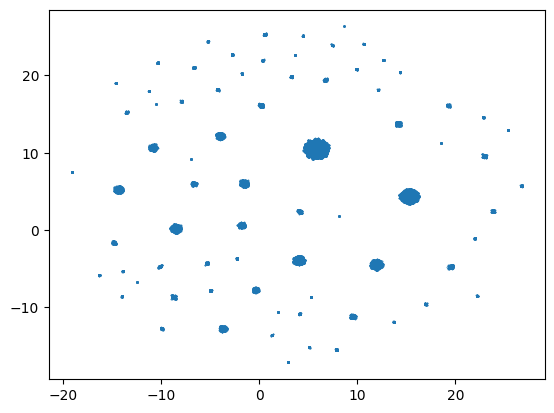

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(one_hot_encoded_data[disease_groups.keys()])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1)

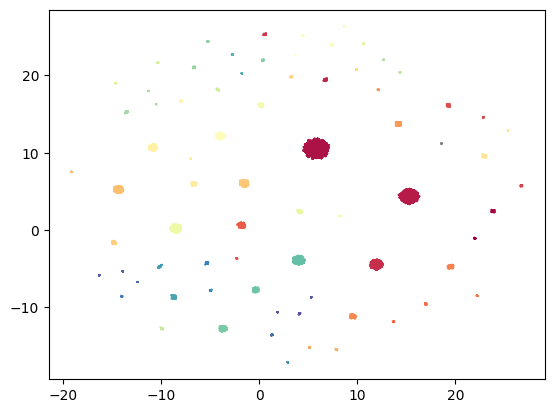

In [ ]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');